## Imports & Path

In [1]:
import os, sys
sys.path.append(os.path.abspath(".."))

import pandas as pd

from src.data_loader import MarketDataConfig, fetch_prices, compute_returns
from src.portfolio import Portfolio, portfolio_returns
from src.var_models import historical_var, parametric_var_normal, parametric_var_ewma_normal, parametric_var_cov_matrix
from src.backtest import var_exceptions, exception_summary, exception_table, kupiec_test_uc
from src.plots import plot_var_overlay
from src.scaling import scale_to_dollars


## Config & Data

In [2]:
cfg = MarketDataConfig(
    tickers=["SPY", "TLT", "GLD", "UUP"],
    start="2015-01-01",
    use_log_returns=True
)

prices = fetch_prices(cfg)
rets = compute_returns(prices, use_log=cfg.use_log_returns)

prices.tail(), rets.tail()


(Ticker             GLD         SPY        TLT     UUP
 Date                                                 
 2026-02-12  451.390015  681.270020  89.230003  26.820
 2026-02-13  462.619995  681.750000  89.720001  26.820
 2026-02-17  448.200012  682.849976  89.870003  26.910
 2026-02-18  458.279999  686.289978  89.529999  27.080
 2026-02-19  458.829987  684.130005  89.464996  27.115,
 Ticker           GLD       SPY       TLT       UUP
 Date                                              
 2026-02-12 -0.035346 -0.015569  0.013199 -0.000373
 2026-02-13  0.024574  0.000704  0.005476  0.000000
 2026-02-17 -0.031666  0.001612  0.001670  0.003350
 2026-02-18  0.022241  0.005025 -0.003790  0.006297
 2026-02-19  0.001199 -0.003152 -0.000726  0.001292)

## Portfolio

In [3]:
port = Portfolio(weights={"SPY": 0.4, "TLT": 0.3, "GLD": 0.2, "UUP": 0.1})
pret = portfolio_returns(rets, port)
NOTIONAL = 10_000_000  # $10mm demo notional 
pnl = scale_to_dollars(pret, NOTIONAL) # use helper to scale pre-trade into dollars  

pret.describe()


count    2798.000000
mean        0.000303
std         0.005437
min        -0.045451
25%        -0.002395
50%         0.000619
75%         0.003173
max         0.049112
Name: portfolio_return, dtype: float64

## VaR Models

In [4]:
WINDOW = 252

# Historical
var95_hist = historical_var(pret, window=WINDOW, alpha=0.05)
var95_hist_dollars = scale_to_dollars(var95_hist, NOTIONAL)
var99_hist = historical_var(pret, window=WINDOW, alpha=0.01)
var99_hist_dollars = scale_to_dollars(var99_hist, NOTIONAL)

# Parametric
var95_param = parametric_var_normal(pret, window=WINDOW, alpha=0.05, use_mean=True)
var95_param_dollars = scale_to_dollars(var95_param, NOTIONAL)
var99_param = parametric_var_normal(pret, window=WINDOW, alpha=0.01, use_mean=True)
var99_param_dollars = scale_to_dollars(var99_param, NOTIONAL)

# Covariance Matrix
var95_cov = parametric_var_cov_matrix(rets, port.weights, window=WINDOW, alpha=0.05, use_mean=True)
var95_cov_dollars = scale_to_dollars(var95_cov, NOTIONAL)
var99_cov = parametric_var_cov_matrix(rets, port.weights, window=WINDOW, alpha=0.01, use_mean=True)
var99_cov_dollars = scale_to_dollars(var99_cov, NOTIONAL)

pd.concat([pret*100, var95_hist_dollars, var95_param_dollars, var99_hist_dollars, var99_param_dollars,var95_cov_dollars,var99_cov_dollars], axis=1).dropna().head()

# EWMA VaR (return space)
var95_ewma = parametric_var_ewma_normal(pret, alpha=0.05, lam=0.94, use_mean=False, burn_in=30)
var99_ewma = parametric_var_ewma_normal(pret, alpha=0.01, lam=0.94, use_mean=False, burn_in=30)

# Scale to dollars (to match pnl and other VaR_$ series)
var95_ewma_dollars = scale_to_dollars(var95_ewma, NOTIONAL)
var99_ewma_dollars = scale_to_dollars(var99_ewma, NOTIONAL)


## Backtest Summaries

In [5]:
b95 = var_exceptions(pnl, var95_hist_dollars)
b99 = var_exceptions(pnl, var99_hist_dollars)
b95_ewma = var_exceptions(pnl, var95_ewma_dollars)
b99_ewma = var_exceptions(pnl, var99_ewma_dollars)
b95_cov = var_exceptions(pnl, var95_cov_dollars)
b99_cov = var_exceptions(pnl, var99_cov_dollars)

sum95 = exception_summary(b95, alpha=0.05)
sum99 = exception_summary(b99, alpha=0.01)
sum95_ewma = exception_summary(b95_ewma, alpha=0.05)
sum99_ewma = exception_summary(b99_ewma, alpha=0.01)
sum95_cov = exception_summary(b95_cov, 0.05)
sum99_cov = exception_summary(b99_cov, 0.01)

pd.DataFrame([sum95, sum95_ewma, sum95_cov, sum99, sum99_ewma, sum99_cov], index=["Roll_95", "EWMA_95","Cov_95", "Roll_99", "EWMA_99", "Cov_99"])

,n_obs,alpha,breaches,expected_breaches,breach_rate
Roll_95,2547,0.05,128,127.35,0.050255
EWMA_95,2768,0.05,130,138.40,0.046965
Cov_95,2547,0.05,123,127.35,0.048292
Roll_99,2547,0.01,33,25.47,0.012956
EWMA_99,2768,0.01,55,27.68,0.019870
Cov_99,2547,0.01,51,25.47,0.020024


## Kupiec Test

In [11]:
kup95 = kupiec_test_uc(b95, alpha=0.05)
kup99 = kupiec_test_uc(b99, alpha=0.01)
kup95_ewma = kupiec_test_uc(b95_ewma, alpha=0.05)
kup99_ewma = kupiec_test_uc(b99_ewma, alpha=0.01)
kup95_cov = kupiec_test_uc(b95_cov, 0.05)
kup99_cov = kupiec_test_uc(b99_cov, 0.01)

print(pd.DataFrame([kup95, kup99], index=["Kupiec_95", "Kupiec_99"]),"\n")
print(pd.DataFrame([kup95, kup95_ewma, kup99, kup99_ewma], index=["Kup_Roll_95", "Kup_EWMA_95", "Kup_Roll_99", "Kup_EWMA_99"]),"\n"
)

def interpret_kupiec(res, sig=0.05):
    return "FAIL (too many/few exceptions)" if res["p_value"] < sig else "PASS (coverage consistent)"

print("Kupiec 95:", interpret_kupiec(kup95), "| p-value:", kup95["p_value"])
print("Kupiec_ewma 95:", interpret_kupiec(kup95_ewma), "| p-value:", kup95_ewma["p_value"])
print("Kupiec_cov 95:", interpret_kupiec(kup95_cov), "| p-value:", kup95_cov["p_value"])
print("Kupiec 99:", interpret_kupiec(kup99), "| p-value:", kup99["p_value"])
print("Kupiec_ewma 99:", interpret_kupiec(kup99_ewma), "| p-value:", kup99_ewma["p_value"])
print("Kupiec_cov 99:", interpret_kupiec(kup99_cov), "| p-value:", kup99_cov["p_value"])

           n_obs  breaches  alpha  breach_rate     lr_uc   p_value
Kupiec_95   2547       128   0.05     0.050255  0.003487  0.952914
Kupiec_99   2547        33   0.01     0.012956  2.056923  0.151516 

             n_obs  breaches  alpha  breach_rate      lr_uc   p_value
Kup_Roll_95   2547       128   0.05     0.050255   0.003487  0.952914
Kup_EWMA_95   2768       130   0.05     0.046965   0.547270  0.459435
Kup_Roll_99   2547        33   0.01     0.012956   2.056923  0.151516
Kup_EWMA_99   2768        55   0.01     0.019870  21.161816  0.000004 

Kupiec 95: PASS (coverage consistent) | p-value: 0.9529141469839706
Kupiec_ewma 95: PASS (coverage consistent) | p-value: 0.4594351804567115
Kupiec_cov 95: PASS (coverage consistent) | p-value: 0.6908900413179357
Kupiec 99: PASS (coverage consistent) | p-value: 0.1515158470152953
Kupiec_ewma 99: FAIL (too many/few exceptions) | p-value: 4.2209074274657254e-06
Kupiec_cov 99: FAIL (too many/few exceptions) | p-value: 7.661853251295092e-06


## Exception Table

In [7]:
# Use helper to get exceptions. Print top 5 of 95% & 99%
exc95 = exception_table(pnl, var95_hist_dollars, top_n=1000)
exc99 = exception_table(pnl, var99_hist_dollars, top_n=1000)

## Save all exceptions to csv files
os.makedirs("../outputs", exist_ok=True)
exc95.to_csv("../outputs/var95_exceptions.csv")
exc99.to_csv("../outputs/var99_exceptions.csv")
print("Saved:", "../outputs/var95_exceptions.csv", "../outputs/var99_exceptions.csv\n")

## Print worst day data
worst_day_95 = exc95.index[0] if len(exc95) else None
if worst_day_95:
    row = exc95.loc[worst_day_95]
    print(f"Worst 95% VaR breach day: {worst_day_95.date()}")
    print(f"Realized P&L: ${row['realized']:,.0f}")
    print(f"VaR threshold: ${row['var']:,.0f}")
    print(f"Exceedance (Realized - VaR): ${row['exceedance']:,.0f}\n")
else:
    print("No breaches found in sample (unexpected for long history).")
print("95% Top 5 worst days\n", exc95.head(), "\n")

worst_day_99 = exc99.index[0] if len(exc99) else None
if worst_day_99:
    row = exc99.loc[worst_day_99]
    print(f"Worst 99% VaR breach day: {worst_day_99.date()}")
    print(f"Realized P&L: ${row['realized']:,.0f}")
    print(f"VaR threshold: ${row['var']:,.0f}")
    print(f"Exceedance (Realized - VaR): ${row['exceedance']:,.0f}\n")
else:
    print("No breaches found in sample (unexpected for long history).")
print("99% Top 5 worst days", exc99.head())


Saved: ../outputs/var95_exceptions.csv ../outputs/var99_exceptions.csv

Worst 95% VaR breach day: 2020-03-12
Realized P&L: $-454,507
VaR threshold: $-59,407
Exceedance (Realized - VaR): $-395,100

95% Top 5 worst days
                  realized            var  breach     exceedance
Date                                                           
2020-03-12 -454506.949889  -59406.650178    True -395100.299711
2020-03-18 -407228.988759  -64189.218121    True -343039.770638
2020-03-16 -330902.981732  -61372.215653    True -269530.766079
2020-03-11 -317986.865510  -57751.466977    True -260235.398533
2022-06-13 -294357.614929 -105286.597925    True -189071.017004 

Worst 99% VaR breach day: 2020-03-12
Realized P&L: $-454,507
VaR threshold: $-203,836
Exceedance (Realized - VaR): $-250,671

99% Top 5 worst days                  realized            var  breach     exceedance
Date                                                           
2020-03-12 -454506.949889 -203835.561891    True -250671

## Plots (in $)

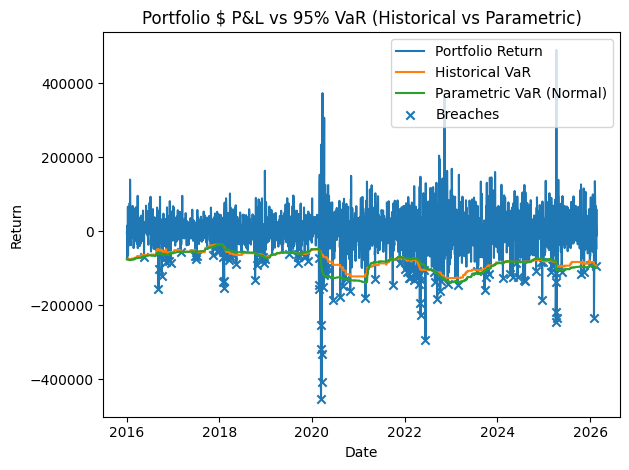

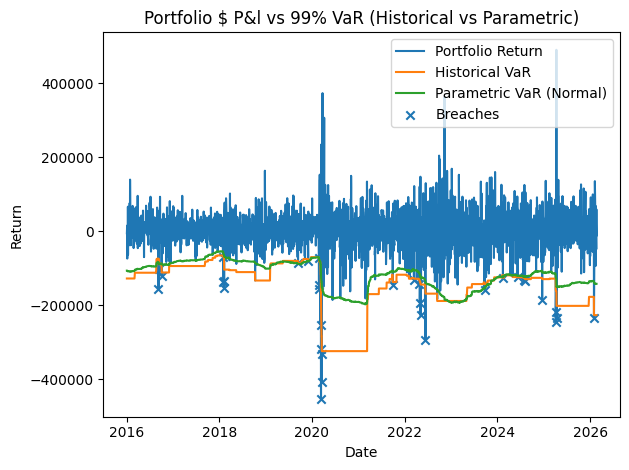

Parametric VAR (Normal) line = EWMA below


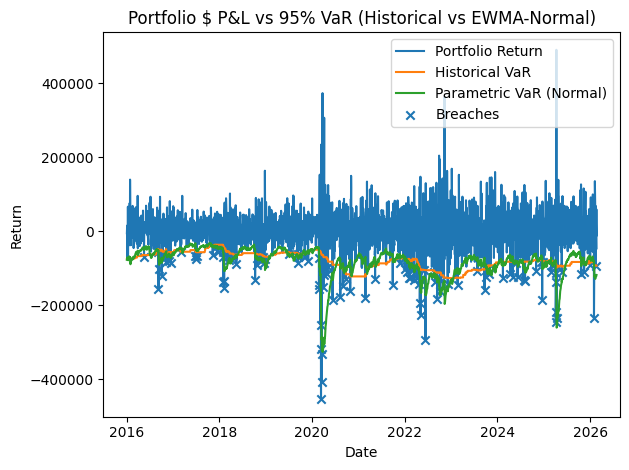

In [8]:
plot_var_overlay(
    returns=pnl,
    var_hist=var95_hist_dollars,
    var_param=var95_param_dollars,
    title="Portfolio $ P&L vs 95% VaR (Historical vs Parametric)",
    outpath="../outputs/figures/var_95_overlay_dollars.png",
)
plot_var_overlay(
    returns=pnl,
    var_hist=var99_hist_dollars,
    var_param=var99_param_dollars,
    title="Portfolio $ P&l vs 99% VaR (Historical vs Parametric)",
    outpath="../outputs/figures/var_99_overlay_dollars.png",
)
print("Parametric VAR (Normal) line = EWMA below")
plot_var_overlay(
    returns=pnl,
    var_hist=var95_hist_dollars,
    var_param=var95_ewma_dollars,
    title="Portfolio $ P&L vs 95% VaR (Historical vs EWMA-Normal)",
    outpath="../outputs/figures/var_95_overlay_ewma.png",
)

## Pre-Trade Impact (Simple)

In [9]:
port_new = Portfolio(weights={"SPY": 0.6, "TLT": 0.2, "GLD": 0.1, "UUP": 0.1})

pret_new = portfolio_returns(rets, port_new)
pnl_new = scale_to_dollars(pret_new, NOTIONAL)

var95_hist_new = historical_var(pret_new, window=WINDOW, alpha=0.05)
var95_param_new = parametric_var_normal(pret_new, window=WINDOW, alpha=0.05, use_mean=True)
var99_hist_new = historical_var(pret_new, window=WINDOW, alpha=0.01)
var99_param_new = parametric_var_normal(pret_new, window=WINDOW, alpha=0.01, use_mean=True)

var95_hist_new_dollars = scale_to_dollars(var95_hist_new, NOTIONAL)
var95_param_new_dollars = scale_to_dollars(var95_param_new, NOTIONAL)
var99_hist_new_dollars = scale_to_dollars(var99_hist_new, NOTIONAL)
var99_param_new_dollars = scale_to_dollars(var99_param_new, NOTIONAL)

comparison = pd.DataFrame({
    "VaR95_hist_old_$": var95_hist_dollars.dropna().round(2),
    "VaR95_hist_new_$": var95_hist_new_dollars.dropna().round(2),
    "VaR95_param_old_$": var95_param_dollars.dropna().round(2),
    "VaR95_param_new_$": var95_param_new_dollars.dropna().round(2),
    "VaR99_hist_old_$": var99_hist_dollars.dropna().round(2),
    "VaR99_hist_new_$": var99_hist_new_dollars.dropna().round(2),
    "VaR99_param_old_$": var99_param_dollars.dropna().round(2),
    "VaR99_param_new_$": var99_param_new_dollars.dropna().round(2),
}).dropna()

comparison.tail().round(2)


,VaR95_hist_old_$,VaR95_hist_new_$,VaR95_param_old_$,VaR95_param_new_$,VaR99_hist_old_$,VaR99_hist_new_$,VaR99_param_old_$,VaR99_param_new_$
Date,,,,,,,,
2026-02-12,-93042.01,-110003.73,-98761.84,-122918.71,-226877.33,-236788.35,-142420.34,-176065.26
2026-02-13,-93042.01,-110003.73,-98309.40,-122524.67,-226877.33,-236788.35,-141976.95,-175647.24
2026-02-17,-93042.01,-110003.73,-98593.78,-122633.52,-226877.33,-236788.35,-142130.19,-175615.55
2026-02-18,-93042.01,-110003.73,-98404.52,-122482.42,-226877.33,-236788.35,-141988.37,-175498.11
2026-02-19,-93042.01,-110003.73,-98507.91,-122623.27,-226877.33,-236788.35,-142098.12,-175647.59


## Summary of Pre-Trade Change

In [10]:
latest = comparison.iloc[-1]
delta_hist_95 = latest["VaR95_hist_new_$"] - latest["VaR95_hist_old_$"]
delta_param_95 = latest["VaR95_param_new_$"] - latest["VaR95_param_old_$"]
delta_hist_99 = latest["VaR99_hist_new_$"] - latest["VaR99_hist_old_$"]
delta_param_99 = latest["VaR99_param_new_$"] - latest["VaR99_param_old_$"]

print("95% VaR Pre-Trade Change")
print(f"VaR95_hist_old_$: {latest['VaR95_hist_old_$']:.2f}")
print(f"VaR95_hist_new_$: {latest['VaR95_hist_new_$']:.2f}")
print(f"VaR95_param_old_$: {latest['VaR95_param_old_$']:.2f}")
print(f"VaR95_param_new_$: {latest['VaR95_param_new_$']:.2f}")
print(f"delta_hist_$: {delta_hist_95:.2f}")
print(f"delta_param_$: {delta_param_95:.2f}\n")
print("99% VaR Pre-Trade Change")
print(f"VaR99_hist_old_$: {latest['VaR99_hist_old_$']:.2f}")
print(f"VaR99_hist_new_$: {latest['VaR99_hist_new_$']:.2f}")
print(f"VaR99_param_old_$: {latest['VaR99_param_old_$']:.2f}")
print(f"VaR99_param_new_$: {latest['VaR99_param_new_$']:.2f}")
print(f"delta_hist_$: {delta_hist_99:.2f}")
print(f"delta_param_$: {delta_param_99:.2f}")


95% VaR Pre-Trade Change
VaR95_hist_old_$: -93042.01
VaR95_hist_new_$: -110003.73
VaR95_param_old_$: -98507.91
VaR95_param_new_$: -122623.27
delta_hist_$: -16961.72
delta_param_$: -24115.36

99% VaR Pre-Trade Change
VaR99_hist_old_$: -226877.33
VaR99_hist_new_$: -236788.35
VaR99_param_old_$: -142098.12
VaR99_param_new_$: -175647.59
delta_hist_$: -9911.02
delta_param_$: -33549.47
